<a href="https://colab.research.google.com/github/yigitv4rli/CENG501-Spring2022/blob/main/Project_Kose_Varli/experiments/fashionmnist_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries here
import torch 
import math
import pandas as pd
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import json
from torch.utils.data import DataLoader
from google.colab import drive

seed_alg = random.randint(0,100)
torch.manual_seed(seed_alg)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Utility Functions

This section includes utility functions for overall model
1. Learning Schedulers
2. Data Loaders
3. Train and Test Accuracy
4. Result Saving
5. Plotting

In [ ]:
# scheduler functions
def constant_learning_rate_scheduler(lr):
    def scheduler(_):
        return lr
    return scheduler

def cosine_learning_rate_scheduler(lr, epoch_count):
    def scheduler(current_epoch):
        return lr * (1 + math.cos(current_epoch * math.pi / epoch_count))
    return scheduler

def diminishing_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr / ((current_epoch + alpha) ** (1/3))
    return scheduler

def exponential_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr * (alpha ** current_epoch)
    return scheduler


# function that saves history a json
def save_history_json(file_name, history):
  with open(file_name, "w") as out:
    json.dump(history, out)

In [ ]:
# data loaders for cifar10 and fashionmnist
def cifar10_loader(batch_size, ssmg):
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    
    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2) 

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    # classes = ('plane', 'car', 'bird', 'cat',
    #        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')     

    return train_loader, test_loader

def fashionmnist_loader(batch_size, ssmg):
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = (0.1307,), std = (0.3081,))]) #Stolen
    
    train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                download=True, transform=transform,) 
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                download=True, transform=transform,) 
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
def train_and_test_accuracy(model, train_loader, test_loader):
    total, correct = 0, 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total

    total, correct = 0, 0
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total

    return train_accuracy, test_accuracy

In [ ]:
def plot_loss(history):
    plt.legend(fontsize = 18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 25)
    plt.ylabel('Train Loss', fontsize = 25)
    plt.yscale('log')
    loss_history = history['loss_history']
    x = [i for i in range(10,210,10)]
    y = [np.sum(loss_history[k:k+10])/10 for k in range(0,200,10)]
    plt.plot(x, y, '-ok', color='blue')

def plot_norm_square_grad(history):
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 18)
    plt.ylabel('Grad loss', fontsize = 18)
    plt.yscale('log')
    grad_history = history['grad_history']
    x = [i for i in range(10,210, 10)]
    y = [np.sum(grad_history[y:y+10])/10 for y in range(0,200,10)]
    plt.plot(x, y, '-ok', color='red')


# Trainers Code Section

## SMG Train Function

In [ ]:
# This trainer trains the net using the SMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors.
def SMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  
  #Note that velocity depends on gradient. So, per each different weight gradient we will have a different velocity, thus different momentum.
  #Therefore, we store velocity and momentum per weight seperately.
  m = dict()
  v = dict()
  # Initialize momentum and velocity dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)
    v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    # At the beginning of each epoch
    # Set m = v
    for n, w in model.named_parameters():
      m[n] = v[n]
    
    # Set v = 0
    for n, w in model.named_parameters():
      v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)


    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      total_loss += loss.item() * normalizer;

      # Backpropagate
      loss.backward()

      # Paper proposes an alternative scheme to update the weights using momentum with batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          #Pytorch computes a batch gradient which is 1/batch_size * grad. In update scheme we use 1/n so we set a grad_scale to compansate that.
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update v
          v[n] += g_scale * w.grad.data
          delta = beta * m[n] + (1-beta) * w.grad.data #weight_update
          w.data += -lr * delta



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

## SSMG Train Function

In [ ]:
# This trainer trains the net using the SSMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors. Also, SSMG is single shuffle variant of SMG so batches wont 
# be reshuffled every epoch.
def SSMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  


  m = dict()
  # Initialize momentum dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
  
    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      #There is no momentum update here. We want to preserve the momentum value of the
      #previous epoch.

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      total_loss += loss.item() * normalizer;

      # Backpropagate
      loss.backward()

      # Paper proposes an alternative scheme to update the weights using momentum with single batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update momentum in every iteration (Most important difference from SMG)
          m[n] = beta * m[n] + (1-beta) * w.grad.data
          w.data += -lr * m[n] #weight_update using the momentum directly



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

## Train Function for Other Optimizers

In [ ]:
# This is a general trainer that uses PyTorch's built-in optimizers.
# This function will be used compare other optimizers with SMG
def train(model, criterion, optimizer, epochs, train_loader, test_loader, scheduler, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """


  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      normalizer = labels.size(0) / len(train_loader.dataset)


      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      total_loss += loss.item() * normalizer;

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      
      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      

    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)

    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')  

  return history

# Networks

In [ ]:
import torch.nn.functional as F
#-------------------------(LeNet5 for Cifar10)-------------------------------
class LeNet5 (nn.Module):
    def __init__ (self):
        super().__init__()

        # This network is for images of size 32x32, with 3 color channels  (Cifar10 dataset)
        self.conv1 = nn.Conv2d (3, 6, 5)
        self.pool = nn.MaxPool2d (2,2)
        self.conv2 = nn.Conv2d (6, 16, 5)
        self.fc1 = nn.Linear (16 * 5 * 5, 120)
        self.fc2 = nn.Linear (120, 84)
        self.fc3 = nn.Linear (84, 10)
    
    def forward (self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #Flatten before passing through the fc layers.
        x = x.view(-1, 16* 5* 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#-------------------------------------------------------------------------------

#---------------(LeNet_300_100 for (Fashion) MNIST)-----------------------------
class LeNet_300_100 (nn.Module):
    def __init__ (self):
        super().__init__()

        # This network is for images of size 28x28, with 1 color channels 
        self.fc1 = nn.Linear (28* 28, 300)
        self.fc2 = nn.Linear (300, 100)
        self.fc3 = nn.Linear (100, 10)
        self.relu = nn.ReLU()
    
    def forward (self, x):
        #Flatten
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#-------------------------------------------------------------------------------

# Get GPU

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!



# Retrieve Datasets

-Cifar10

In [ ]:
cifar_train_loader, cifar_test_loader = cifar10_loader(256, False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


-Fashion MNIST

In [ ]:
fashion_train_loader, fashion_test_loader = fashionmnist_loader(128, False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# 1- Train and Plot Different Learning Schedulers over SMG

## SMG with Constant Learning Rate Scheduler

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epoch_count = 200


scheduler = constant_learning_rate_scheduler(0.1)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, fashion_train_loader, fashion_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 0.6661217845280965
avg. grad_norm of last epoch 3.392758872083561
Current train acc: 81.78166666666667%, test acc: 80.98%
Epoch 2 / 200: avg. loss of last epoch 0.42256548759142537
avg. grad_norm of last epoch 2.6710406523145287
Current train acc: 86.64666666666666%, test acc: 85.36%
Epoch 3 / 200: avg. loss of last epoch 0.3548604269504546
avg. grad_norm of last epoch 1.7961944311298734
Current train acc: 87.57333333333334%, test acc: 86.04%
Epoch 4 / 200: avg. loss of last epoch 0.3181741418202717
avg. grad_norm of last epoch 1.8628070763973246
Current train acc: 88.57666666666667%, test acc: 86.5%
Epoch 5 / 200: avg. loss of last epoch 0.29067653000354776
avg. grad_norm of last epoch 1.6711818020718578
Current train acc: 89.89%, test acc: 87.48%
Epoch 6 / 200: avg. loss of last epoch 0.27248399482568125
avg. grad_norm of last epoch 1.9624789570109649
Current train acc: 89.69166666666666%, test acc: 87.28%
Epoch 7 / 200: avg. loss of last epoch 

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-Fashion-History/SMG_constantLR.json", history)

No handles with labels found to put in legend.


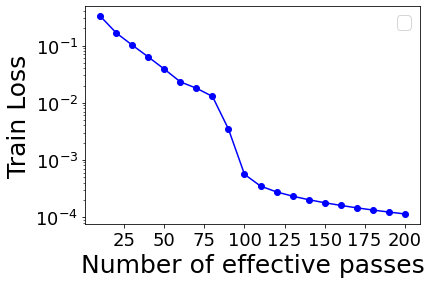

In [ ]:
plot_loss(history)

## SMG with Diminishing Learning Rate Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epoch_count = 200

scheduler = diminishing_learning_rate_scheduler(0.5, 8)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, fashion_train_loader, fashion_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 0.5894082794348398
avg. grad_norm of last epoch 2.3874413855381813
Current train acc: 84.73666666666666%, test acc: 83.11%
Epoch 2 / 200: avg. loss of last epoch 0.3776697783946996
avg. grad_norm of last epoch 1.5184543741233723
Current train acc: 87.61333333333333%, test acc: 85.9%
Epoch 3 / 200: avg. loss of last epoch 0.3194019393761953
avg. grad_norm of last epoch 1.2073727563911911
Current train acc: 87.55333333333333%, test acc: 85.38%
Epoch 4 / 200: avg. loss of last epoch 0.28482826221783974
avg. grad_norm of last epoch 1.2577542319134813
Current train acc: 88.22166666666666%, test acc: 85.97%
Epoch 5 / 200: avg. loss of last epoch 0.25837258192698137
avg. grad_norm of last epoch 1.201577858403576
Current train acc: 91.21666666666667%, test acc: 87.97%
Epoch 6 / 200: avg. loss of last epoch 0.23959880392551416
avg. grad_norm of last epoch 1.2593490437158128
Current train acc: 91.26166666666667%, test acc: 87.55%
Epoch 7 / 200: avg. loss of

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-Fashion-History/SMG_diminishingLR.json", history)

No handles with labels found to put in legend.


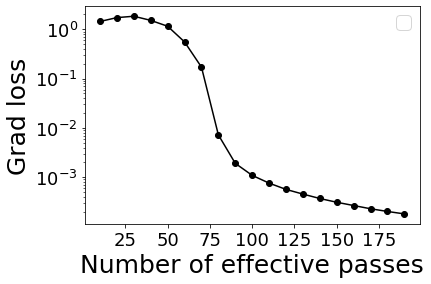

In [ ]:
plot_norm_square_grad(history)

## SMG with Exponential Learning Rate Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epoch_count = 200

scheduler = exponential_learning_rate_scheduler(0.5, 0.99)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, fashion_train_loader, fashion_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 0.5841343516667694
avg. grad_norm of last epoch 1.7348294259170973
Current train acc: 83.71333333333334%, test acc: 82.39%
Epoch 2 / 200: avg. loss of last epoch 0.37164061287244204
avg. grad_norm of last epoch 0.9904368161663547
Current train acc: 87.76166666666667%, test acc: 85.97%
Epoch 3 / 200: avg. loss of last epoch 0.31106686391830446
avg. grad_norm of last epoch 0.7456487726347281
Current train acc: 89.45333333333333%, test acc: 87.03%
Epoch 4 / 200: avg. loss of last epoch 0.279557768615087
avg. grad_norm of last epoch 0.78593297983633
Current train acc: 89.90666666666667%, test acc: 87.19%
Epoch 5 / 200: avg. loss of last epoch 0.2523863086859387
avg. grad_norm of last epoch 0.7426933666597456
Current train acc: 90.43166666666667%, test acc: 87.25%
Epoch 6 / 200: avg. loss of last epoch 0.2368125064611435
avg. grad_norm of last epoch 0.8300114979027872
Current train acc: 91.7%, test acc: 88.2%
Epoch 7 / 200: avg. loss of last epoch 0.21

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-Fashion-History/SMG_ExponentialLR.json", history)

No handles with labels found to put in legend.


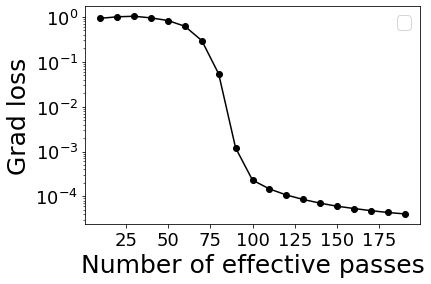

In [ ]:
plot_norm_square_grad(history)

## SMG with Cosine Learning Rate Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epoch_count = 200

scheduler = cosine_learning_rate_scheduler(0.2, epoch_count)

# beta is proposed in paper and epoch_count is inferred from the graphs
history = SMG_train(model, criterion, epoch_count, fashion_train_loader, fashion_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 0.5730958459218347
avg. grad_norm of last epoch 1.8773445127527044
Current train acc: 84.785%, test acc: 83.56%
Epoch 2 / 200: avg. loss of last epoch 0.3728693809032445
avg. grad_norm of last epoch 1.142103092769356
Current train acc: 86.885%, test acc: 85.29%
Epoch 3 / 200: avg. loss of last epoch 0.312507641855876
avg. grad_norm of last epoch 0.8864043559914895
Current train acc: 88.01333333333334%, test acc: 85.45%
Epoch 4 / 200: avg. loss of last epoch 0.2786109353383382
avg. grad_norm of last epoch 0.8837874946185255
Current train acc: 89.52666666666667%, test acc: 86.73%
Epoch 5 / 200: avg. loss of last epoch 0.2538440137386323
avg. grad_norm of last epoch 0.8519220902015847
Current train acc: 89.96833333333333%, test acc: 86.86%
Epoch 6 / 200: avg. loss of last epoch 0.2354987569173177
avg. grad_norm of last epoch 0.9176968464270828
Current train acc: 91.515%, test acc: 88.06%
Epoch 7 / 200: avg. loss of last epoch 0.21642026374340048
avg.

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-Fashion-History/SMG_CosineLR.json", history)

No handles with labels found to put in legend.


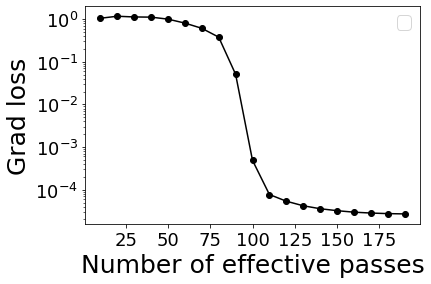

In [ ]:
plot_norm_square_grad(history)

# 2- Train Other Models and Compare over SMG

## Training with Adam


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epochs = 200

scheduler = constant_learning_rate_scheduler(0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

adam_history = train(model, criterion, optimizer, epochs, fashion_train_loader, fashion_test_loader, scheduler)

Epoch 1 / 200: avg. loss of last epoch 0.48673670961062077
Epoch 1 / 200: avg. grad_norm of last epoch 4.26902308308329
Current train acc: 86.565%, test acc: 84.89%
Epoch 2 / 200: avg. loss of last epoch 0.3453824382623037
Epoch 2 / 200: avg. grad_norm of last epoch 1.7487252241015345
Current train acc: 88.24166666666666%, test acc: 86.36%
Epoch 3 / 200: avg. loss of last epoch 0.3066909615993498
Epoch 3 / 200: avg. grad_norm of last epoch 1.4216633813913202
Current train acc: 89.49%, test acc: 87.12%
Epoch 4 / 200: avg. loss of last epoch 0.2856005764166516
Epoch 4 / 200: avg. grad_norm of last epoch 1.25135683471796
Current train acc: 89.815%, test acc: 87.28%
Epoch 5 / 200: avg. loss of last epoch 0.26643116269111633
Epoch 5 / 200: avg. grad_norm of last epoch 1.1628374063389804
Current train acc: 90.575%, test acc: 87.74%
Epoch 6 / 200: avg. loss of last epoch 0.2494454373995463
Epoch 6 / 200: avg. grad_norm of last epoch 1.015888019488301
Current train acc: 91.55666666666667%, tes

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Fashion-Other-Optimizers/ADAM_constantLR.json", adam_history)

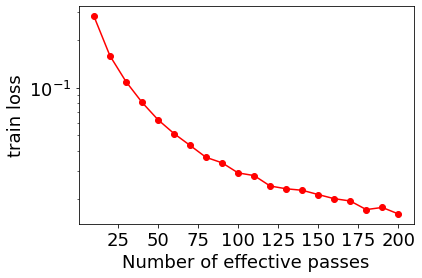

In [ ]:
plot_loss(adam_history)

## Training with SGD


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epochs = 200

scheduler = constant_learning_rate_scheduler(0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1)

sgd_history = train(model, criterion, optimizer, epochs, fashion_train_loader, fashion_test_loader, scheduler)

Epoch 1 / 200: avg. loss of last epoch 0.5965861408392584
Epoch 1 / 200: avg. grad_norm of last epoch 2.564945111934229
Current train acc: 83.90666666666667%, test acc: 82.77%
Epoch 2 / 200: avg. loss of last epoch 0.3984734286944068
Epoch 2 / 200: avg. grad_norm of last epoch 1.8134560962129436
Current train acc: 85.07666666666667%, test acc: 83.65%
Epoch 3 / 200: avg. loss of last epoch 0.35636524116198226
Epoch 3 / 200: avg. grad_norm of last epoch 1.7143495102947484
Current train acc: 87.70333333333333%, test acc: 85.95%
Epoch 4 / 200: avg. loss of last epoch 0.3262043552875518
Epoch 4 / 200: avg. grad_norm of last epoch 1.6463634237883817
Current train acc: 87.94%, test acc: 86.14%
Epoch 5 / 200: avg. loss of last epoch 0.3044315915902455
Epoch 5 / 200: avg. grad_norm of last epoch 1.6019350966056554
Current train acc: 90.07333333333334%, test acc: 87.48%
Epoch 6 / 200: avg. loss of last epoch 0.28832117958068826
Epoch 6 / 200: avg. grad_norm of last epoch 1.6336430958064616
Curre

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Fashion-Other-Optimizers/SGD_constantLR.json", sgd_history)

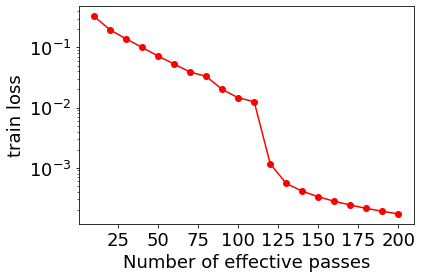

In [ ]:
plot_loss(sgd_history)

## Training with SGD-M

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epochs = 200

scheduler = constant_learning_rate_scheduler(0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

sgdm_history = train(model, criterion, optimizer, epochs, fashion_train_loader, fashion_test_loader, scheduler)

Epoch 1 / 200: avg. loss of last epoch 0.5265689983367925
Epoch 1 / 200: avg. grad_norm of last epoch 2.203323254980231
Current train acc: 85.255%, test acc: 84.22%
Epoch 2 / 200: avg. loss of last epoch 0.3649269423484808
Epoch 2 / 200: avg. grad_norm of last epoch 1.4324729568200016
Current train acc: 87.79333333333334%, test acc: 85.82%
Epoch 3 / 200: avg. loss of last epoch 0.3279834268252057
Epoch 3 / 200: avg. grad_norm of last epoch 1.4087870502289095
Current train acc: 88.08333333333333%, test acc: 86.24%
Epoch 4 / 200: avg. loss of last epoch 0.3004998928070065
Epoch 4 / 200: avg. grad_norm of last epoch 1.2846484686092934
Current train acc: 89.15%, test acc: 86.82%
Epoch 5 / 200: avg. loss of last epoch 0.2808242664019266
Epoch 5 / 200: avg. grad_norm of last epoch 1.2535945827248853
Current train acc: 90.015%, test acc: 87.23%
Epoch 6 / 200: avg. loss of last epoch 0.26692433131535853
Epoch 6 / 200: avg. grad_norm of last epoch 1.30101703815272
Current train acc: 91.105%, te

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Fashion-Other-Optimizers/SGD-M_constantLR.json", sgdm_history)

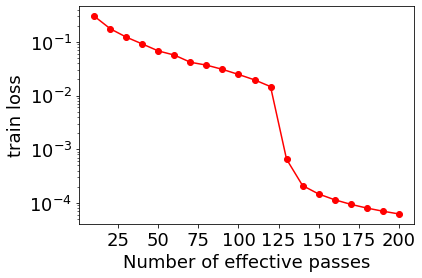

In [ ]:
plot_loss(sgdm_history)

## Training with SSMG


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

model = LeNet_300_100()
model = model.to(device)
epoch_count = 200


scheduler = constant_learning_rate_scheduler(0.2)

#SSMG is single shuffle variant of the SMG (with different optimizer step.) 
#Thus, reload the batch by shuffling it once and disable shuffling in every epoch
fashion_train_loader, fashion_test_loader = fashionmnist_loader(128, True)

# beta is proposed in paper and epoch_count is inferenced from the graphs
ssmgHistory = SSMG_train(model, criterion, epoch_count, fashion_train_loader, fashion_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 0.533162461773555
avg. grad_norm of last epoch 2.1530154910322468
Current train acc: 83.83166666666666%, test acc: 82.52%
Epoch 2 / 200: avg. loss of last epoch 0.3685311560312913
avg. grad_norm of last epoch 1.5144792919988934
Current train acc: 86.42666666666666%, test acc: 84.76%
Epoch 3 / 200: avg. loss of last epoch 0.32564437292416876
avg. grad_norm of last epoch 1.3799010300351686
Current train acc: 87.735%, test acc: 85.63%
Epoch 4 / 200: avg. loss of last epoch 0.2974340852896371
avg. grad_norm of last epoch 1.3006394647332382
Current train acc: 88.445%, test acc: 85.97%
Epoch 5 / 200: avg. loss of last epoch 0.27606966770489955
avg. grad_norm of last epoch 1.281248979995513
Current train acc: 88.66166666666666%, test acc: 86.02%
Epoch 6 / 200: avg. loss of last epoch 0.2588917136987051
avg. grad_norm of last epoch 1.2906826899176482
Current train acc: 89.64166666666667%, test acc: 86.76%
Epoch 7 / 200: avg. loss of last epoch 0.243283771

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Fashion-Other-Optimizers/SSMG_constantLR.json", ssmgHistory)

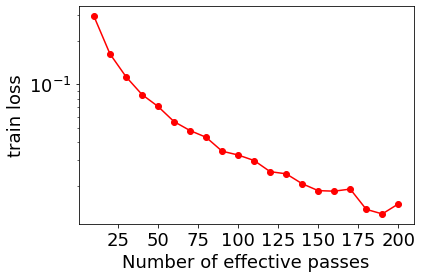

In [ ]:
plot_loss(ssmgHistory)